### Import Libraries

In [1]:
#import libraries needed
import os
import json
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import geocoder # import geocoder
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from IPython.display import *
import ipywidgets as widgets
from ipywidgets import *

import folium # map rendering library
#set jupiter to widescreen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from fastkml import kml
import ipyleaflet
from ipyleaflet import *
import geopandas as gpd
from shapely.geometry import Point, LineString



### Initialize Foursquare Credentials

In [2]:
#Initialize Foursquare credentials
CLIENT_ID = 'X4SJA3AV3FTZ22OEQXP55EHFQLTOUCZKGTSCC5F2JOQO501J' # your Foursquare ID
CLIENT_SECRET = 'MYAZ3IBXZRWJZR1PDTQONDIHCM13IRJDI12TFEUQFEFZQADG' # your Foursquare Secret
ACCESS_TOKEN = '45U4RLZCPAHXURFJBXLSCVEMY1R3IBZYIJT1ELCAM1D5PPJV' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: X4SJA3AV3FTZ22OEQXP55EHFQLTOUCZKGTSCC5F2JOQO501J
CLIENT_SECRET:MYAZ3IBXZRWJZR1PDTQONDIHCM13IRJDI12TFEUQFEFZQADG


# Set Pandas Options

In [3]:
pd.set_option('display.max_rows', 100)

### Import Neigborhood Lat/Lon

In [4]:
Den_Neigh_LatLon = pd.read_csv(r'g:\DataScienceProjects\Coursera_Captone\Resources\Denver Neighborhood Lat_Long.csv')
Den_Neigh_LatLon

Neighborhood  Latitude  Longitude
0                    Athmar Park  39.70386 -105.01114
1                        Auraria  39.74551 -105.00685
2                          Baker  39.71478 -104.99394
3                         Barnum  39.71823 -105.03247
4                    Barnum West  39.71813 -105.04625
5                    Bear Valley  39.66168 -105.06200
6                        Belcaro  39.70363 -104.94993
7                       Berkeley  39.77615 -105.03942
8                            CBD  39.74593 -104.99243
9                   Capitol Hill  39.73515 -104.97865
10                  Central Park  39.77553 -104.87715
11                  Chaffee Park  39.78776 -105.01341
12                 Cheesman Park  39.73508 -104.96620
13                  Cherry Creek  39.72092 -104.94977
14                     City Park  39.74521 -104.95117
15                City Park West  39.74603 -104.96677
16                  Civic Center  39.73488 -104.99020
17                       Clayton  39.76814 -104.94986
18                          Cole  39.76665 -104.96609
19   College View - South Platte  39.66842 -105.01273
20                 Congress Park  39.73362 -104.94952
21                Cory - Merrill  39.69104 -104.95020
22                  Country Club  39.72374 -104.96583
23                           DIA  39.84855 -104.69204
24                   East Colfax  39.74001 -104.89274
25                Elyria Swansea  39.78445 -104.95712
26                   Five Points  39.75906 -104.98106
27                    Fort Logan  39.64254 -105.04187
28  Gateway - Green Valley Ranch  39.78341 -104.77204
29                    Globeville  39.77939 -104.98295
30                     Goldsmith  39.67568 -104.91583
31                          Hale  39.73290 -104.93162
32                       Hampden  39.65995 -104.89137
33                 Hampden South  39.64126 -104.89721
34                   Harvey Park  39.67416 -105.03814
35             Harvey Park South  39.66049 -105.03981
36                      Highland  39.76329 -105.01110
37                       Hilltop  39.71789 -104.92462
38                  Indian Creek  39.68562 -104.89690
39                Jefferson Park  39.75240 -105.01930
40                       Kennedy  39.65391 -104.86210
41                  Lincoln Park  39.73352 -105.00509
42                         Lowry  39.71973 -104.89060
43                       Mar Lee  39.68947 -105.03906
44                       Marston  39.63366 -105.08269
45                     Montbello  39.78671 -104.83627
46                     Montclair  39.73291 -104.91247
47            North Capitol Hill  39.74402 -104.98105
48               North Park Hill  39.75659 -104.92231
49           Northeast Park Hill  39.77442 -104.92227
50                      Overland  39.68199 -104.99162
51                    Platt Park  39.68744 -104.98028
52                         Regis  39.78750 -105.04380
53                      Rosedale  39.67294 -104.97909
54                     Ruby Hill  39.69021 -105.01035
55                       Skyland  39.75755 -104.94992
56                    Sloan Lake  39.75204 -105.03807
57               South Park Hill  39.74633 -104.92171
58                Southmoor Park  39.63864 -104.91137
59                         Speer  39.71927 -104.98102
60                    Sun Valley  39.73648 -105.02175
61                     Sunnyside  39.77650 -105.01290
62                 Union Station  39.75361 -105.00052
63                    University  39.67489 -104.96698
64             University Hills   39.66386 -104.93325
65               University Park  39.67649 -104.94937
66                      Valverde  39.71693 -105.01629
67                    Villa Park  39.73059 -105.03948
68              Virginia Village  39.68781 -104.92596
69               Washington Park  39.70208 -104.96505
70          Washington Park West  39.70201 -104.97930
71      Washington Virginia Vale  39.70362 -104.91647
72                     Wellshire  39.66151 -104.94965
73                   Wes

In [5]:
with open('.\Resources\statistical_neighborhoods.geojson', 'r') as f:
    denver_geojson = f.read()



Function to pull venue data from Foursquare using neighborhood lat/lng

In [6]:
#Function to pull venue information about each postal code
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
#make a 1d list of each item and append to columns
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# check if denver_venues exists, import as dataframe, else query foursquare to create dataframe denver_venues

In [7]:
from os import path

if os.path.isfile('./Resources/denver_venues.csv'):
    
    denver_venues = pd.read_csv('./Resources/denver_venues.csv', index_col =[0])
   
    
    print("denver_venues.csv exists and read")
else:
    denver_venues = getNearbyVenues(names = Den_Neigh_LatLon['Neighborhood'],
                                 latitudes = Den_Neigh_LatLon['Latitude'],
                                 longitudes = Den_Neigh_LatLon['Longitude'])
        
    denver_venues.to_csv( './Resources/denver_venues.csv')


denver_venues.head(20)

denver_venues.csv exists and read


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0       Auraria              39.745821             -105.008267   
1       Auraria              39.745821             -105.008267   
2       Auraria              39.745821             -105.008267   
3       Auraria              39.745821             -105.008267   
4       Auraria              39.745821             -105.008267   
5       Auraria              39.745821             -105.008267   
6       Auraria              39.745821             -105.008267   
7       Auraria              39.745821             -105.008267   
8       Auraria              39.745821             -105.008267   
9       Auraria              39.745821             -105.008267   
10      Auraria              39.745821             -105.008267   
11      Auraria              39.745821             -105.008267   
12      Auraria              39.745821             -105.008267   
13      Auraria              39.745821             -105.008267   
14      Auraria              39.745821             -105.008267   
15      Auraria              39.745821             -105.008267   
16      Auraria              39.745821             -105.008267   
17      Auraria              39.745821             -105.008267   
18      Auraria              39.745821             -105.008267   
19      Auraria              39.745821             -105.008267   

                                Venue  Venue Latitude  Venue Longitude  \
0              Tivoli Brewing Company       39.745494      -105.005475   
1                          Ball Arena       39.748700      -105.007600   
2   SpringHill Suites Denver Downtown       39.747537      -105.003805   
3                     Alfresco Greens       39.744905      -105.005778   
4                Orangetheory Fitness       39.750981      -105.003716   
5                         Mind Eraser       39.749562      -105.013887   
6                           Boomerang       39.748360      -105.014364   
7                          Rhein Haus       39.748346      -105.000537   
8                            Coohills       39.750764      -105.003832   
9        Biker Jim's @ Auraria Campus       39.745109      -105.004855   
10  Elitch Gardens Theme & Water Park       39.750045      -105.010761   
11           Society Sports & Spirits       39.749143      -105.000865   
12                   Celtic On Market       39.747929      -105.000428   
13            Starbucks In The Tivoli       39.744730      -105.005798   
14                      Tower of Doom       39.748204      -105.014133   
15                Ted's Montana Grill       39.747541      -104.999834   
16                      Panda Express       39.749512      -105.009819   
17             Off-Center @ The Jones       39.744499      -104.999729   
18                             Dazbog       39.745415      -105.007474   
19                        King Center       39.743330      -105.006062   

                  Venue Category  
0                        Brewery  
1             Basketball Stadium  
2                          Hotel  
3                    Salad Place  
4                            Gym  
5   Theme Park Ride / Attraction  
6   Theme Park Ride / Attraction  
7              German Restaurant  
8              French Restaurant  
9                  Hot Dog Joint  
10                    Theme Park  
11                           Bar  
12                     Irish Pub  
13                   Coffee Shop  
14  Theme Park Ride / Attraction  
15           American Restaurant  
16            Chinese Restaurant  
17                       Theater  
18                   Coffee Shop  
19                       Theater

In [8]:
#How many venues in each neighborhood
denver_venues.groupby('Neighborhood').count()


Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                                  
Athmar Park                                      10                      10   
Auraria                                          32                      32   
Baker                                            38                      38   
Barnum                                           14                      14   
Barnum West                                       4                       4   
Bear Valley                                       4                       4   
Belcaro                                           2                       2   
Berkeley                                         63                      63   
CBD                                             100                     100   
Capitol Hill                                    100                     100   
Central Park                                     13                      13   
Chaffee Park                                     13                      13   
Cheesman Park                                    53                      53   
Cherry Creek                                     81                      81   
City Park                                        84                      84   
City Park West                                   68                      68   
Civic Center                                     86                      86   
Clayton                                           8                       8   
Cole                                             29                      29   
College View - South Platte                      10                      10   
Congress Park                                    21                      21   
Cory - Merrill                                   13                      13   
Country Club                                     35                      35   
DIA                                              12                      12   
East Colfax                                      23                      23   
Elyria Swansea                                   15                      15   
Five Points                                      95                      95   
Fort Logan                                        4                       4   
Gateway - Green Valley Ranch                     35                      35   
Globeville                                       19                      19   
Goldsmith                                        37                      37   
Hale                                             12                      12   
Hampden                                           2                       2   
Hampden South                                    18                      18   
Harvey Park                                       4                       4   
Harvey Park South                                 2                       2   
Highland                                         86                      86   
Hilltop                                          14                      14   
Indian Creek                                      4                       4   
Jefferson Park                                   47                      47   
Kennedy                                          12                      12   
Lincoln Park                                     36                      36   
Lowry Field                                      28                      28   
Mar Lee                                           8                       8   
Marston                                           1                       1   
Montbello                                         5                       5   
Montclair                                        18                      18   
North Capitol Hill                               98                      98   
North Park Hill                                   8                       8   
N

In [9]:
print('There are {} unique categories.'.format(len(denver_venues['Venue Category'].unique())))

There are 298 unique categories.


In [10]:
# one hot encoding
denver_onehot = pd.get_dummies(denver_venues[['Venue Category']], prefix="", prefix_sep="")
#Replace Neighborhood column
denver_onehot['Neighborhood'] = denver_venues['Neighborhood'] 
#locate neighborhood
neigh_loc = denver_onehot.columns.get_loc('Neighborhood')
#move Neighborhood to front
fixed_columns = [denver_onehot.columns[neigh_loc]] + list(denver_onehot.columns)
denver_onehot = denver_onehot[fixed_columns]
#dropping duplicate ['Neighborhood']
denver_onehot = denver_onehot.loc[:,~denver_onehot.columns.duplicated()]

denver_onehot.head()

Neighborhood  ATM  Accessories Store  Acupuncturist  African Restaurant  \
0      Auraria    0                  0              0                   0   
1      Auraria    0                  0              0                   0   
2      Auraria    0                  0              0                   0   
3      Auraria    0                  0              0                   0   
4      Auraria    0                  0              0                   0   

   Airport  Airport Gate  Airport Lounge  Airport Service  Airport Terminal  \
0        0             0               0                0                 0   
1        0             0               0                0                 0   
2        0             0               0                0                 0   
3        0             0               0                0                 0   
4        0             0               0                0                 0   

   ...  Weight Loss Center  Whisky Bar  Wine Bar  Wine Shop  Winery  \
0  ...                   0           0         0          0       0   
1  ...                   0           0         0          0       0   
2  ...                   0           0         0          0       0   
3  ...                   0           0         0          0       0   
4  ...                   0           0         0          0       0   

   Wings Joint  Women's Store  Yoga Studio  Zoo  Zoo Exhibit  
0            0              0            0    0            0  
1            0              0            0    0            0  
2            0              0            0    0            0  
3            0              0            0    0            0  
4            0              0            0    0            0  

[5 rows x 298 columns]

In [11]:

#Find mean occurence of each category ie scale
denver_grouped = denver_onehot.groupby(['Neighborhood']).mean()
denver_grouped.reset_index(inplace = True)
#create a denver_cluster before denver_grouped is altered
denver_cluster = pd.DataFrame(denver_grouped)



In [12]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [13]:
#Function to create sorted data frame with top 10 most common venues
def top_ten_venues(df) : 
    num_top_venues = 10
    indicators = ['st', 'nd', 'rd']
    
    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))
    
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = df['Neighborhood'] 
    
    for ind in np.arange(denver_grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df.iloc[ind, :], num_top_venues)
    #important to have a return in a function, this is the output that can be attached to a variable
    return neighborhoods_venues_sorted
    

In [14]:
#creating a variable to hold the df for later access
neighborhoods_venues_sorted = top_ten_venues(denver_grouped)
neighborhoods_venues_sorted = neighborhoods_venues_sorted.set_index(['Neighborhood'])

In [15]:
denver_geojson = '.\Resources\statistical_neighborhoods.geojson'


gdf = gpd.read_file(denver_geojson)[['NBHD_NAME', 'geometry']]
#gdf = gdf.set_index("NBHD_NAME")
gdf.columns = ['Neighborhood', 'geometry']


print(gdf.crs)
gdf


epsg:4326


Neighborhood  \
0                        Auraria   
1                 Cory - Merrill   
2                        Belcaro   
3                Washington Park   
4           Washington Park West   
5                          Speer   
6                   Cherry Creek   
7                   Country Club   
8                  Congress Park   
9                      City Park   
10                       Marston   
11                    Fort Logan   
12                        Barnum   
13                   Barnum West   
14                   West Colfax   
15                 West Highland   
16                    Sloan Lake   
17                      Berkeley   
18                         Regis   
19                  Chaffee Park   
20                      Highland   
21                   Athmar Park   
22                     Wellshire   
23                    University   
24                      Rosedale   
25                 Cheesman Park   
26                       Hilltop   
27                     Montclair   
28                          Hale   
29               North Park Hill   
30               South Park Hill   
31               University Park   
32                    Platt Park   
33                      Overland   
34                     Ruby Hill   
35                       Kennedy   
36                       Hampden   
37                Southmoor Park   
38                 Hampden South   
39                  Indian Creek   
40                     Goldsmith   
41              University Hills   
42                   Harvey Park   
43                       Mar Lee   
44                   East Colfax   
45                  Capitol Hill   
46            North Capitol Hill   
47                  Civic Center   
48                           CBD   
49                 Union Station   
50                  Central Park   
51                     Montbello   
52                   Lowry Field   
53  Gateway - Green Valley Ranch   
54             Harvey Park South   
55   College View - South Platte   
56                City Park West   
57                    Sun Valley   
58                      Valverde   
59                    Villa Park   
60                   Five Points   
61                    Globeville   
62                   Bear Valley   
63              Virginia Village   
64                       Windsor   
65      Washington Virginia Vale   
66                Jefferson Park   
67           Northeast Park Hill   
68                Elyria Swansea   
69                         Baker   
70                       Clayton   
71                       Skyland   
72                  Lincoln Park   
73                      Whittier   
74                          Cole   
75                      Westwood   
76                     Sunnyside   
77                           DIA   

                                             geometry  
0   POLYGON ((-105.00042 39.74552, -105.00041 39.7...  
1   POLYGON ((-104.94070 39.69540, -104.94070 39.6...  
2   POLYGON ((-104.94070 39.71156, -104.94069 39.7...  
3   POLYGON ((-104.95931 39.71566, -104.95931 39.7...  
4   POLYGON ((-104.97342 39.68982, -104.97356 39.6...  
5   POLYGON ((-104.97325 39.71840, -104.97323 39.7...  
6   POLYGON ((-104.94070 39.71156, -104.94091 39.7...  
7   POLYGON ((-104.96017 39.72561, -104.96015 39.7...  
8   POLYGON ((-104.94066 39.74013, -104.94066 39.7...  
9   POLYGON ((-104.94062 39.75104, -104.94063 39.7...  
10  POLYGON ((-105.06507 39.61852, -105.06509 39.6...  
11  POLYGON ((-105.03462 39.65328, -105.03463 39.6...  
12  POLYGON ((-105.02514 39.72554, -105.02514 39.7...  
13  POLYGON ((-105.03945 39.72571, -105.03945 39.7...  
14  POLYGON ((-105.02521 39.74636, -105.02521 39.7...  
15  POLYGON ((-105.02524 39.76929, -105.02525 39.7...  
16  POLYGON ((-105.02523 39.75848, -105.02524 39.7...  
17  POLYGON ((-105.02519 39.78438, -105.02519 39.7...  
18  POLYGON ((-105.02995 39.79203, -105.02994 39.7...  
19  POLYGON ((-105.02056 39.79290, -105.02054 39.7...  

# Functioning dropdown that displays specific Neighborhoods and data and outputs selected neighborhood as variable geometry for mapping

In [16]:
#model Jupyter dropdown
#initialized filtered_df to become a global that is update in the the dropdown selection
filtered_df = None

#Dropdown pulling from filtered dataframe of neighborhoods
dropdown = widgets.SelectMultiple(
                        options=neighborhoods_venues_sorted.index,
                        description='Neighborhood',
                        disabled=False,
                        layout={'height':'100px', 'width':'20%'})

#function to filter dataframe based on dropdown selection and cast to global variable filtered_df
def filter_dataframe(widget):
    global filtered_df
    selection = list(widget['new'])

    with out:
        clear_output()
        display(neighborhoods_venues_sorted.loc[selection])        
        filtered_df = neighborhoods_venues_sorted.loc[selection]
    
    #Reset index so that Neighborhood is a column
    df=filtered_df.reset_index()
#loop to find index value of neighborhood
    for i in gdf['Neighborhood'] :
    
        if i == df['Neighborhood'][0]:
        
            geometry = (gdf[gdf.Neighborhood == i].index)
    #print(geometry)
        

out = widgets.Output()
dropdown.observe(filter_dataframe, names='value')
display(dropdown)
display(out)




SelectMultiple(description='Neighborhood', layout=Layout(height='100px', width='20%'), options=('Athmar Park',…

Output()

# Ipyleaflet map experiments

In [17]:
df=filtered_df.reset_index()


    #loop to find index value of neighborhood
for i in gdf['Neighborhood'] :
    
    if i == df['Neighborhood'][0]:
        
        geometry = (gdf[gdf.Neighborhood == i].index)
       
m = Map(center = (39.73515, -104.97865), zoom = 12.2, basemap = basemaps.Stamen.Toner)




geo_data = GeoData(geo_dataframe = gdf)
neighborhood_data = GeoData(geo_dataframe = gdf.loc[geometry], 
                           style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')



m.add_layer(geo_data)
m.add_layer(neighborhood_data)
m

AttributeError: 'NoneType' object has no attribute 'reset_index'

In [18]:
str(filtered_df['1st Most Common Venue'])

TypeError: 'NoneType' object is not subscriptable

In [21]:
#Finding K
Sum_of_squared_distances = []
K = range(1,77)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(denver_grouped)
    Sum_of_squared_distances.append(km.inertia_)

ValueError: could not convert string to float: 'Athmar Park'

ValueError: x and y must have same first dimension, but have shapes (76,) and (0,)

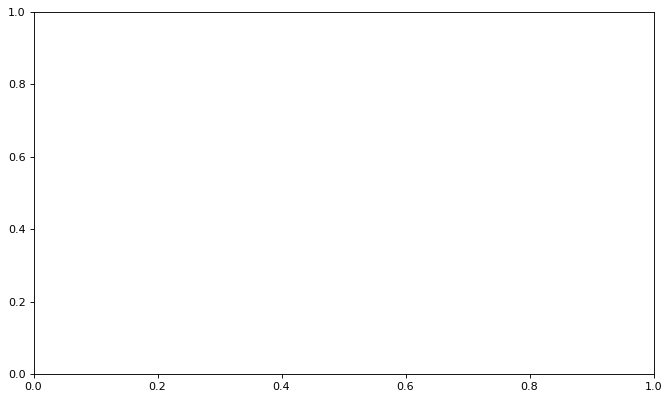

In [20]:
figure(figsize = (10,6), dpi = 80)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# set number of clusters
kclusters = 55

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(denver_grouped_clustering)

# check cluster labels generated for each row in the dataframe}
kmeans.labels_[0:10] 

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

denver_merged = denver_venues

# merge denver_grouped with denver_data to add latitude/longitude for each neighborhood
denver_merged = denver_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

denver_merged.head() # check the last columns!

In [ ]:
denver_grpd = denver_merged
denver_grpd = denver_merged.groupby('Neighborhood')
denver_grpd

# Exploring data


In [ ]:
def cluster(df) : 
    
    denver_cluster = pd.DataFrame(df)


    denver_cluster.insert(0, 'Cluster Labels', kmeans.labels_)
cluster(denver_grouped)


In [ ]:
#Isolate cluster and neighborhood columns witg Latitude a
denver_neigh = pd.DataFrame()
denver_neigh = denver_merged[['Cluster Labels','Neighborhood','Neighborhood Latitude','Neighborhood Longitude']]
denver_neigh = denver_neigh.drop_duplicates().set_index('Neighborhood').sort_values('Cluster Labels')
denver_neigh



#grouping and merging Neighborhood field, I think this may be unnecessary
denver_neigh['Neighborhood'] = denver_neigh.groupby(['Cluster Labels'])['Neighborhood'].transform(lambda x : ','.join(x))
denver_neigh =denver_neigh.groupby(['Cluster Labels']).sum()


In [ ]:
#how to add neighborhoods as values to cluster columns
denver_neigh_group = denver_neigh.groupby('Cluster Labels')
denver_neigh_group

Add cluster Labels to denver_grouped

In [ ]:
#New dataframe from denver_cluster

cluster(denver_grouped)
#Group by Cluster Label and replace Neighborhood with merged Neighorhood fields with commas in between
denver_cluster['Neighborhood'] = denver_cluster.groupby(['Cluster Labels'])['Neighborhood'].transform(lambda x : ','.join(x))

#reset index to Neighborhoodand sort by cluster labels

denver_cluster = denver_cluster.set_index(['Neighborhood']).sort_values(by = ['Cluster Labels'])


In [ ]:
denver_cluster

In [ ]:
#Group by Neighborhood and sum venue values to find density
denver_cluster = denver_cluster
denver_cluster_grpd=denver_cluster.groupby(['Neighborhood']).sum()
denver_cluster_grpd.reset_index()



In [ ]:
#sort entire column by greatest density of venue
denver_cluster_grpd['Coffee Shop'].sort_values(ascending = False)

In [ ]:
denver_cluster_grpd.nlargest(10,'Coffee Shop')

In [ ]:
def max_coffee:
     denver_cluster_grpd['Movie Theater'].idxmax()

print("The densest cluster of coffee shops is in cluster :",max_coffee_index)